<a href="https://colab.research.google.com/github/reenu-supreeta/Protein-LMs/blob/main/Protein_LMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.4 MB/s eta 0:00:00
Using device: cuda
Building GO-labeled dataset...


Reading GO mappings: 199579901it [09:02, 367727.02it/s]


Saved dataset: go_labeled_dataset.csv
Proteins: 15332 | GO classes: 52
Splits created.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]


100%|██████████| 384/384 [05:40<00:00,  1.13it/s]



Running split 100%


100%|██████████| 1534/1534 [22:41<00:00,  1.13it/s]



Running split 10%


100%|██████████| 154/154 [02:15<00:00,  1.13it/s]



Running split 5%


100%|██████████| 77/77 [01:07<00:00,  1.13it/s]



Running split 1%


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


,Split,Train_Size,AA_F1,3MER_F1,4MER_F1
0,100%,12265,0.7123,0.0920,0.1005
1,10%,1226,0.2986,0.0498,0.0564
2,5%,613,0.1595,0.0353,0.0350
3,1%,122,0.0452,0.0188,0.0179


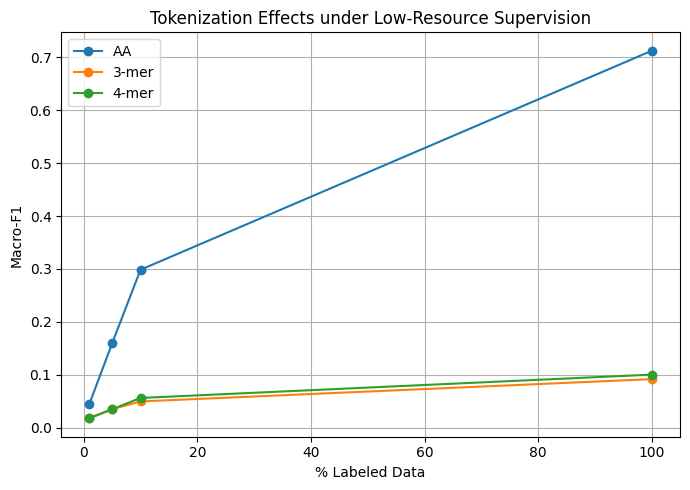


Vocabulary & Sparsity Analysis:


,Tokenization,Vocab_Size,Avg_Tokens_per_Seq,Rare_Token_%
0,AA,21,399.14,0.00
1,3-mer,8047,397.14,1.06
2,4-mer,137493,396.14,44.49


Running k-mer-only baseline on 100%
Running k-mer-only baseline on 10%
Running k-mer-only baseline on 5%
Running k-mer-only baseline on 1%

K-mer-only baseline:


,Split,Train_Size,3MER_ONLY_F1,4MER_ONLY_F1
0,100%,12265,0.7897,0.7920
1,10%,1226,0.4920,0.4520
2,5%,613,0.3965,0.3398
3,1%,122,0.1141,0.0913


In [ ]:

# -------------------- INSTALLS --------------------
!pip install -q torch transformers biopython pandas numpy tqdm scikit-learn matplotlib

# -------------------- IMPORTS --------------------
import os, gzip
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel

# -------------------- DEVICE --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# GLOBAL SETTINGS
# ============================================================

MAX_SEQS = 20000
MIN_GO_FREQ = 50
TEST_SIZE = 0.2
RANDOM_SEED = 42
LOW_RESOURCE_LEVELS = [1.0, 0.10, 0.05, 0.01]

BATCH_SIZE = 8
MAX_LEN = 512

FASTA_FILE = "uniprot_sprot.fasta.gz"
MAPPING_FILE = "idmapping_selected.tab.gz"
DATASET_FILE = "go_labeled_dataset.csv"
TEST_FILE = "test_split_fixed.csv"

FASTA_URL = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
MAPPING_URL = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/idmapping_selected.tab.gz"

# ============================================================
# 1️⃣ DOWNLOAD FILES (ONCE)
# ============================================================

if not os.path.exists(FASTA_FILE):
    print("Downloading Swiss-Prot FASTA...")
    !wget -q $FASTA_URL

if not os.path.exists(MAPPING_FILE):
    print("Downloading UniProt GO mapping...")
    !wget -q $MAPPING_URL

# ============================================================
# 2️⃣ BUILD OR LOAD GO-LABELED DATASET
# ============================================================

if not os.path.exists(DATASET_FILE):
    print("Building GO-labeled dataset...")

    records = []
    with gzip.open(FASTA_FILE, "rt") as handle:
        for i, record in enumerate(SeqIO.parse(handle, "fasta")):
            if i >= MAX_SEQS:
                break
            records.append({
                "uniprot_id": record.id.split("|")[1],
                "sequence": str(record.seq)
            })

    seq_df = pd.DataFrame(records)
    go_map = {}
    wanted = set(seq_df["uniprot_id"])

    with gzip.open(MAPPING_FILE, "rt") as f:
        for line in tqdm(f, desc="Reading GO mappings"):
            parts = line.rstrip("\n").split("\t")
            if len(parts) >= 7 and parts[0] in wanted and parts[6]:
                go_map[parts[0]] = parts[6].split(";")[0]

    df = seq_df[seq_df["uniprot_id"].isin(go_map)].copy()
    df["go_label"] = df["uniprot_id"].map(go_map)

    counts = df["go_label"].value_counts()
    df = df[df["go_label"].isin(counts[counts >= MIN_GO_FREQ].index)]

    df.to_csv(DATASET_FILE, index=False)
    print("Saved dataset:", DATASET_FILE)

else:
    df = pd.read_csv(DATASET_FILE)
    print("Loaded existing GO-labeled dataset")

print(f"Proteins: {len(df)} | GO classes: {df['go_label'].nunique()}")

# ============================================================
# 3️⃣ CREATE OR LOAD SPLITS
# ============================================================

if not os.path.exists(TEST_FILE):
    train_df, test_df = train_test_split(
        df, test_size=TEST_SIZE,
        stratify=df["go_label"],
        random_state=RANDOM_SEED
    )

    splits = {}
    for frac in LOW_RESOURCE_LEVELS:
        if frac == 1.0:
            split_df = train_df.copy()
        else:
            split_df, _ = train_test_split(
                train_df, train_size=frac,
                stratify=train_df["go_label"],
                random_state=RANDOM_SEED
            )
        name = f"{int(frac*100)}%"
        split_df.to_csv(f"train_split_{name}.csv", index=False)
        splits[name] = split_df

    test_df.to_csv(TEST_FILE, index=False)
    print("Splits created.")

else:
    print("Loading existing splits...")
    test_df = pd.read_csv(TEST_FILE)
    splits = {
        "100%": pd.read_csv("train_split_100%.csv"),
        "10%":  pd.read_csv("train_split_10%.csv"),
        "5%":   pd.read_csv("train_split_5%.csv"),
        "1%":   pd.read_csv("train_split_1%.csv"),
    }

# ============================================================
# 4️⃣ LOAD PROTBERT
# ============================================================

tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = AutoModel.from_pretrained("Rostlab/prot_bert").to(device)
model.eval()

# ============================================================
# TOKENIZERS
# ============================================================

def aa_tokenize(seq):
    return " ".join(list(seq))

def kmer_tokenize(seq, k):
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))

# ============================================================
# 5️⃣ EMBEDDING WITH DISK CACHING
# ============================================================

def embed(seqs, tok_fn, cache_file):
    if os.path.exists(cache_file):
        return np.load(cache_file)

    embs = []
    for i in tqdm(range(0, len(seqs), BATCH_SIZE)):
        batch = [tok_fn(s) for s in seqs[i:i+BATCH_SIZE]]
        enc = tokenizer(batch, return_tensors="pt",
                        padding=True, truncation=True, max_length=MAX_LEN)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            pooled = model(**enc).last_hidden_state.mean(dim=1)
        embs.append(pooled.cpu().numpy())

    embs = np.vstack(embs)
    np.save(cache_file, embs)
    return embs

# ============================================================
# 6️⃣ RUN EXPERIMENTS (AA vs 3-mer vs 4-mer)
# ============================================================

label_encoder = LabelEncoder()
label_encoder.fit(pd.concat(splits.values())["go_label"])
y_test = label_encoder.transform(test_df["go_label"])

X_test_aa = embed(test_df["sequence"].tolist(), aa_tokenize, "X_test_aa.npy")
X_test_3  = embed(test_df["sequence"].tolist(), lambda s: kmer_tokenize(s,3), "X_test_3.npy")
X_test_4  = embed(test_df["sequence"].tolist(), lambda s: kmer_tokenize(s,4), "X_test_4.npy")

results = []

for name, train_df in splits.items():
    print(f"\nRunning split {name}")
    y_train = label_encoder.transform(train_df["go_label"])

    Xtr_aa = embed(train_df["sequence"].tolist(), aa_tokenize, f"Xtr_aa_{name}.npy")
    Xtr_3  = embed(train_df["sequence"].tolist(), lambda s: kmer_tokenize(s,3), f"Xtr_3_{name}.npy")
    Xtr_4  = embed(train_df["sequence"].tolist(), lambda s: kmer_tokenize(s,4), f"Xtr_4_{name}.npy")

    clf = LogisticRegression(max_iter=2000, n_jobs=-1)

    clf.fit(Xtr_aa, y_train)
    f1_aa = f1_score(y_test, clf.predict(X_test_aa), average="macro")

    clf.fit(Xtr_3, y_train)
    f1_3 = f1_score(y_test, clf.predict(X_test_3), average="macro")

    clf.fit(Xtr_4, y_train)
    f1_4 = f1_score(y_test, clf.predict(X_test_4), average="macro")

    results.append({
        "Split": name,
        "Train_Size": len(train_df),
        "AA_F1": round(f1_aa,4),
        "3MER_F1": round(f1_3,4),
        "4MER_F1": round(f1_4,4),
    })

# ============================================================
# 7️⃣ RESULTS TABLE + PLOT
# ============================================================

results_df = pd.DataFrame(results)
display(results_df)

x = [100, 10, 5, 1]
plt.figure(figsize=(7,5))
plt.plot(x, results_df["AA_F1"], marker="o", label="AA")
plt.plot(x, results_df["3MER_F1"], marker="o", label="3-mer")
plt.plot(x, results_df["4MER_F1"], marker="o", label="4-mer")
plt.xlabel("% Labeled Data")
plt.ylabel("Macro-F1")
plt.title("Tokenization Effects under Low-Resource Supervision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 8️⃣ VOCABULARY SIZE + SPARSITY ANALYSIS
# ============================================================

from collections import Counter

def analyze_tokenization(seqs, tok_fn, name):
    token_counts = Counter()
    total_tokens = 0

    for s in seqs:
        toks = tok_fn(s).split()
        token_counts.update(toks)
        total_tokens += len(toks)

    vocab_size = len(token_counts)
    avg_tokens = total_tokens / len(seqs)
    rare_frac = sum(c < 5 for c in token_counts.values()) / vocab_size

    return {
        "Tokenization": name,
        "Vocab_Size": vocab_size,
        "Avg_Tokens_per_Seq": round(avg_tokens, 2),
        "Rare_Token_%": round(100 * rare_frac, 2),
    }

sample_seqs = df["sequence"].sample(3000, random_state=42).tolist()

vocab_stats = [
    analyze_tokenization(sample_seqs, aa_tokenize, "AA"),
    analyze_tokenization(sample_seqs, lambda s: kmer_tokenize(s,3), "3-mer"),
    analyze_tokenization(sample_seqs, lambda s: kmer_tokenize(s,4), "4-mer"),
]

vocab_df = pd.DataFrame(vocab_stats)
print("\nVocabulary & Sparsity Analysis:")
display(vocab_df)

# ============================================================
# 9️⃣ K-MER ONLY BASELINE (NO PROTBERT)
# ============================================================

from sklearn.feature_extraction.text import CountVectorizer

def run_kmer_only(train_df, test_df, k):
    vectorizer = CountVectorizer(
        analyzer="char",
        ngram_range=(k, k),
        min_df=2,
        max_features=50000
    )

    X_train = vectorizer.fit_transform(train_df["sequence"])
    X_test  = vectorizer.transform(test_df["sequence"])

    y_train = label_encoder.transform(train_df["go_label"])
    y_test  = label_encoder.transform(test_df["go_label"])

    clf = LogisticRegression(max_iter=2000, n_jobs=-1)
    clf.fit(X_train, y_train)

    return f1_score(y_test, clf.predict(X_test), average="macro")

# ---- RUN BASELINES ----

kmer_only_results = []

for name, train_df in splits.items():
    print(f"Running k-mer-only baseline on {name}")

    f1_3_only = run_kmer_only(train_df, test_df, k=3)
    f1_4_only = run_kmer_only(train_df, test_df, k=4)

    kmer_only_results.append({
        "Split": name,
        "Train_Size": len(train_df),
        "3MER_ONLY_F1": round(f1_3_only, 4),
        "4MER_ONLY_F1": round(f1_4_only, 4),
    })

kmer_only_df = pd.DataFrame(kmer_only_results)
print("\nK-mer-only baseline:")
display(kmer_only_df)
